In [5]:
import pandas as pd
import numpy as np
import glob

In [8]:
CAND_DIR = "cand_loose"
corrections = ["centJER", "jes_up", "jes_down", "jes_up_old", "jes_down_old", "jer_up", "jer_down", "tau_eup", "tau_edown"]

def get_samples():

    files = glob.glob( CAND_DIR + "/*.h5")
    samples = {}
    for sample in files:
        sample_name = sample.split("/")[-1][:-3]
        print(sample_name)
        if (sample_name != "Data") & (sample_name != "QCD"):
            for key in ["central", "met_up", "met_down"] + corrections:
                samples[sample_name + "_" + key] = pd.read_hdf(sample, sample_name + "_" + key)
        else:
            samples[sample_name] = pd.read_hdf(sample)
            
    return samples

In [9]:
samples = get_samples()

Data
QCD
STJets
TTJets_bkg
TTJets_signal
WZJets


In [15]:
import ml
import xgboost as xgb

In [85]:
n_sig = 2000
n_bkg = 2000

print("Prepare training data")

signal = samples["TTJets_signal_central"]
bkg = samples["QCD"]

ml.train_test_split(signal, n_sig)
ml.train_test_split(bkg, n_bkg)

print(list(signal))

signal["label"] = 0
bkg["label"] = 1

signal_train = signal[signal["train_flag"] == "train"]
signal_train["weights"] = signal_train['trigger_weight'] * signal_train['Jet_btag_weight1']
signal_train["weights"] = signal_train["weights"] * (1. / np.mean(signal_train["weights"]))
signal_test = signal[signal["train_flag"] == "test"]
bkg_train = bkg[bkg["train_flag"] == "train"]
bkg_train["weights"] = bkg_train['btag_weight']
bkg_train["weights"] = bkg_train["weights"] * (1. / np.mean(bkg_train["weights"]))
bkg_test = bkg[bkg["train_flag"] == "test"]

train_data = pd.concat([signal_train, bkg_train], axis=0)
test_data = pd.concat([signal_test, bkg_test], axis=0)

features = ['ht', 'aplanarity', 'sphericity', 'chargeEta', 'met', 'deltaPhiTauMet', 'mt', 'mTauJet']

X_train = train_data[features].values
y_train = train_data["label"].values.ravel()
weights = train_data["weights"]
print(weights)

X_test = test_data[features].values
y_test = test_data["label"].values.ravel()   

print("Train model")

# Define model
bdt = xgb.XGBClassifier(n_estimators=100, learning_rate = 0.01, n_jobs = 1)
# Fit
bdt.fit(X_train, y_train, sample_weight = weights, eval_metric=["logloss"], verbose=False) # sample_weight

# Predict
print("Predicting...") 

for sample in samples:
    samples[sample]["bdt"] = bdt.predict_proba(samples[sample][features].values)[:,0]  

Prepare training data
['Jet_pt', 'Jet_px', 'Jet_py', 'Jet_pz', 'Jet_e', 'Jet_eta', 'Jet_phi', 'Jet_mass', 'Jet_csvDisc', 'Jet_flavour', 'Tau_pt', 'Tau_px', 'Tau_py', 'Tau_pz', 'Tau_e', 'Tau_eta', 'Tau_phi', 'Tau_mass', 'Tau_charge', 'MET_pt', 'MET_px', 'MET_py', 'MET_pz', 'MET_e', 'MET_met', 'event', 'run', 'luminosityBlock', 'HLT_QuadJet40_IsoPFTau40', 'HLT_QuadJet45_IsoPFTau45', 'genEvent_tmeme', 'nJets', 'Jet_nbtags', 'ht', 'aplanarity', 'sphericity', 'chargeEta', 'met', 'deltaPhiTauMet', 'mt', 'mTauJet', 'Jet_btagSF', 'Jet_btagSF_up', 'Jet_btagSF_down', 'Jet_beff', 'Jet_btag_weight1', 'Jet_btag_weight1_up', 'Jet_btag_weight1_down', 'trigger_weight', 'trigger_weight_up', 'trigger_weight_down', 'norm', 'norm_up', 'norm_down', 'train_flag', 'label', 'bdt', 'weight']


/usr/local/bin/start_ipykernel.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/start_ipykernel.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/start_ipykernel.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/start_ipykernel.py:23: SettingWithCopyWarning: 
A value is

30       0.849871
61       0.956582
67       0.949445
124      1.091163
143      0.932452
154      0.925847
171      0.880310
172      1.268768
181      0.908416
200      1.171950
232      1.343667
253      0.964281
255      0.857096
278      1.209957
325      1.057746
380      0.992935
441      1.201258
464      0.939857
602      1.012981
658      0.971818
663      0.976313
700      1.120789
710      0.909063
779      0.613621
785      0.427401
804      0.846595
806      1.045453
812      0.761928
818      1.113538
848      1.355090
           ...   
11069    1.207874
11086    0.991832
11089    1.251850
11093    1.180739
11108    1.131770
11110    1.232479
11114    0.955414
11122    0.918858
11125    0.905786
11130    0.919254
11133    1.006185
11140    0.872200
11141    0.911258
11143    1.247176
11147    1.188529
11148    1.068234
11149    1.145025
11163    1.009497
11166    0.966856
11167    0.914951
11169    0.961553
11170    0.906184
11177    0.905420
11185    0.957087
11186    0

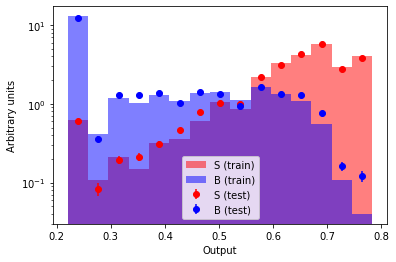

In [86]:
# Plot
ml.compare_train_test(bdt, X_train, y_train, X_test, y_test, bins=15)

In [87]:
import ROOT
from root_numpy import fill_hist

def save_var(sample, name, var_name, bins = 20, xlow = 0., xup = 350, corr=None):

    print( name, var_name, corr )
    
    if corr is None:
        hist = ROOT.TH1D(name + "_" + var_name, name + "_" + var_name, bins, xlow, xup)
    else:
        hist = ROOT.TH1D(name + "_" + corr + "_" + var_name, name + "_" + var_name + "_" + corr, bins, xlow, xup)
    hist.Sumw2()
    
    if name == "Data":
        pass
    elif name == "QCD":
        if var_name == "bdt":
            scale_qcd = 9.
            sample = sample[sample["train_flag"] == "test"]
        else:
            scale_qcd = 4.3
        sample['weight'] = sample['btag_weight'] * scale_qcd
    else:
        #samples[sample]['new_trigger_weight'] = new_samples[sample].apply(lambda ev : weights.trigger_weight(ev), axis=1)
        if corr is None:
            sample['weight'] = sample['norm'] * (1/1000) * sample['trigger_weight'] * sample['Jet_btag_weight1']
        elif corr == "btag_up":
            sample['weight'] = sample['norm'] * (1/1000) * sample['trigger_weight'] * sample['Jet_btag_weight1_up']
        elif corr == "btag_down":
            sample['weight'] = sample['norm'] * (1/1000) * sample['trigger_weight'] * sample['Jet_btag_weight1_down']
        elif corr == "trigger_up":
            sample['weight'] = sample['norm'] * (1/1000) * sample['trigger_weight_up'] * sample['Jet_btag_weight1']
        elif corr == "trigger_down":
            sample['weight'] = sample['norm'] * (1/1000) * sample['trigger_weight_down'] * sample['Jet_btag_weight1']
        elif corr == "xsec_up":
            sample['weight'] = sample['norm_up'] * (1/1000) * sample['trigger_weight'] * sample['Jet_btag_weight1']
        elif corr == "xsec_down":
            sample['weight'] = sample['norm_down'] * (1/1000) * sample['trigger_weight'] * sample['Jet_btag_weight1']
        elif corr == "pdf_up":
            sample['weight'] = sample['norm'] * (1/1000) * sample['trigger_weight'] * sample['Jet_btag_weight1'] *                   (1+sample['pdf_up'])
        elif corr == "pdf_down":
            sample['weight'] = sample['norm'] * (1/1000) * sample['trigger_weight'] * sample['Jet_btag_weight1']  * (1-sample['pdf_down'])
        else:
            print( "No valid correction" )

        #print(sample, sum(samples[sample]['weight']))
        #new_samples[sample]['btag_weight2']
    
    series = sample[var_name]
    if name != "Data":
        weights = sample["weight"]
    if name == "Data":
        fill_hist(hist, series)
    else:
        fill_hist(hist, series, weights = weights)

    return hist
        
    
def vars_to_histos(samples, variables):
    
    hists = {}    
    for name, sample in samples.items():
        for var in variables:
            hists[name + "_" + var["var_name"]] = save_var(sample, name, var["var_name"], var["bins"], var["xlow"], var["xup"])
            if "centJER" in name:
                for corr in ["btag_up", "btag_down", "trigger_up", "trigger_down", "xsec_up", "xsec_down"]:
                    hists[name + "_" + var["var_name"]] = save_var(sample, name, var["var_name"], var["bins"], var["xlow"], var["xup"], corr = corr)
                if "TTJets" in name:
                    hists[name + "_" + var["var_name"]] = save_var(sample, name, var["var_name"], var["bins"], var["xlow"], var["xup"], corr = "pdf_up")
                    hists[name + "_" + var["var_name"]] = save_var(sample, name, var["var_name"], var["bins"], var["xlow"], var["xup"], corr = "pdf_down")

    return hists

In [90]:
variables = [
    {"var_name" : "bdt", "bins" : 15, "xlow" : 0., "xup" : 1., "xtitle" : 0.}
]

hists = vars_to_histos(samples, variables)

Data bdt None
QCD bdt None


/usr/local/bin/start_ipykernel.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


STJets_central bdt None
STJets_met_up bdt None
STJets_met_down bdt None
STJets_centJER bdt None
STJets_centJER bdt btag_up
STJets_centJER bdt btag_down
STJets_centJER bdt trigger_up
STJets_centJER bdt trigger_down
STJets_centJER bdt xsec_up
STJets_centJER bdt xsec_down
STJets_jes_up bdt None
STJets_jes_down bdt None
STJets_jes_up_old bdt None
STJets_jes_down_old bdt None
STJets_jer_up bdt None
STJets_jer_down bdt None
STJets_tau_eup bdt None
STJets_tau_edown bdt None
TTJets_bkg_central bdt None
TTJets_bkg_met_up bdt None
TTJets_bkg_met_down bdt None
TTJets_bkg_centJER bdt None
TTJets_bkg_centJER bdt btag_up
TTJets_bkg_centJER bdt btag_down
TTJets_bkg_centJER bdt trigger_up
TTJets_bkg_centJER bdt trigger_down
TTJets_bkg_centJER bdt xsec_up
TTJets_bkg_centJER bdt xsec_down
TTJets_bkg_centJER bdt pdf_up
TTJets_bkg_centJER bdt pdf_down
TTJets_bkg_jes_up bdt None
TTJets_bkg_jes_down bdt None
TTJets_bkg_jes_up_old bdt None
TTJets_bkg_jes_down_old bdt None
TTJets_bkg_jer_up bdt None
TTJets_bk

Warning in <TFile::Append>: Replacing existing TH1: Data_bdt (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: QCD_bdt (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: STJets_jes_down_bdt (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: TTJets_bkg_jes_down_bdt (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: TTJets_signal_jes_down_bdt (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: WZJets_jes_down_bdt (Potential memory leak).


In [89]:
f = ROOT.TFile("histos/bdt_test.root")
fit_var = "bdt"
corr="jes_down"
histos = {}
for s in sample_names:
    print(s)
    if (s != "Data") & (s != "QCD"):
        if ("pdf" in corr) & ("TTJets" in s):
            hist = f.Get(s + "_" + corr +"_" + fit_var)
        elif ("pdf" in corr):
            hist = f.Get(s + "_" + "centJER" + "_" + fit_var)
        else:
            hist = f.Get(s + "_" + corr +"_" + fit_var)
            #hist = f.Get(s + "_" + fit_var)
    else:
        hist = f.Get(s + "_" + fit_var)
    hist.Sumw2()
    print( s, hist.Integral() )
    histos[s] = hist

Data
Data 3343.0
TTJets_bkg
TTJets_bkg 140.4289202766023
WZJets
WZJets 62.43401415239289
STJets
STJets 29.514357300815966
QCD
QCD 3803.05693706975
TTJets_signal
TTJets_signal 338.2703270110722


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


In [91]:
def fit(histos, fit_var, corr = "central"):
    
    
    bkg = histos['TTJets_bkg' + "_" + corr + "_" + fit_var ].Clone()
    bkg.Add(histos['WZJets'  + "_" + corr  + "_" + fit_var ])
    bkg.Add(histos['STJets' + "_" + corr  + "_" + fit_var ])

    data = histos["Data" + "_" + fit_var ].Clone()
    data.Add(bkg, -1.)

    signal = histos["TTJets_signal" + "_" + corr  + "_" + fit_var ]

    qcd = histos["QCD" + "_" + fit_var ]
    """
    
    bkg = histos['TTJets_bkg'].Clone()
    bkg.Add(histos['WZJets'])
    bkg.Add(histos['STJets'])

    data = histos["Data"].Clone()
    data.Add(bkg, -1.)

    signal = histos["TTJets_signal"]

    qcd = histos["QCD"]
    """
    x = ROOT.RooRealVar("x","x",0.,350.)
    rooSignal =  ROOT.RooDataHist("signal","signal",ROOT.RooArgList( x ), signal)
    rooBkg = ROOT.RooDataHist("bkg","bkg", ROOT.RooArgList( x ), qcd)
    signal_pdf = ROOT.RooHistPdf("signal","signal",ROOT.RooArgSet( x ), rooSignal)
    bkg_pdf = ROOT.RooHistPdf("bkg","bkg",ROOT.RooArgSet( x ), rooBkg)

    c0 = ROOT.RooRealVar("c0","c0",0.5,0.,1.)
    pdf = ROOT.RooAddPdf("pdf","pdf", signal_pdf,bkg_pdf, c0)

    dataFit = ROOT.RooDataHist("data","data",ROOT.RooArgList( x ), data);

    fitResult = pdf.fitTo(dataFit)
    #print( fitResult )

    sf_tt_sig = (c0.getVal() * data.Integral()) / signal.Integral() 
    sf_tt_sig_err = (c0.getError() * data.Integral()) / signal.Integral()
    
    sf_qcd = ((1-c0.getVal())*data.Integral()) / qcd.Integral()
    sf_qcd_err = (c0.getError() * data.Integral()) / qcd.Integral()
    
    
    print( "scale factor TTbar tau(h) QQ ", sf_tt_sig, "+-", sf_tt_sig_err )
    print( "scale factor MultiJet ", sf_qcd, "+-", sf_qcd_err )

    return sf_tt_sig, sf_qcd

In [ ]:
fit(hists, "bdt", "centJER")

In [34]:
hists.keys()

dict_keys(['Data_bdt', 'QCD_bdt', 'STJets_central_bdt', 'STJets_met_up_bdt', 'STJets_met_down_bdt', 'STJets_centJER_bdt', 'STJets_jes_up_bdt', 'STJets_jes_down_bdt', 'STJets_jes_up_old_bdt', 'STJets_jes_down_old_bdt', 'STJets_jer_up_bdt', 'STJets_jer_down_bdt', 'STJets_tau_eup_bdt', 'STJets_tau_edown_bdt', 'TTJets_bkg_central_bdt', 'TTJets_bkg_met_up_bdt', 'TTJets_bkg_met_down_bdt', 'TTJets_bkg_centJER_bdt', 'TTJets_bkg_jes_up_bdt', 'TTJets_bkg_jes_down_bdt', 'TTJets_bkg_jes_up_old_bdt', 'TTJets_bkg_jes_down_old_bdt', 'TTJets_bkg_jer_up_bdt', 'TTJets_bkg_jer_down_bdt', 'TTJets_bkg_tau_eup_bdt', 'TTJets_bkg_tau_edown_bdt', 'TTJets_signal_central_bdt', 'TTJets_signal_met_up_bdt', 'TTJets_signal_met_down_bdt', 'TTJets_signal_centJER_bdt', 'TTJets_signal_jes_up_bdt', 'TTJets_signal_jes_down_bdt', 'TTJets_signal_jes_up_old_bdt', 'TTJets_signal_jes_down_old_bdt', 'TTJets_signal_jer_up_bdt', 'TTJets_signal_jer_down_bdt', 'TTJets_signal_tau_eup_bdt', 'TTJets_signal_tau_edown_bdt', 'WZJets_cent

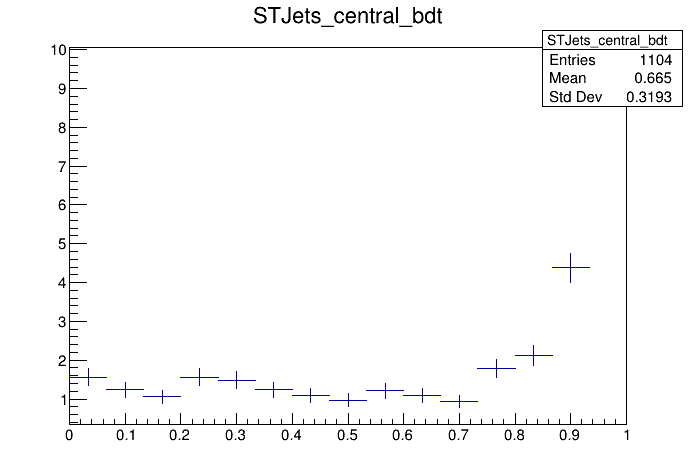

In [37]:
c = ROOT.TCanvas()
hists["STJets_central_bdt"].Draw()
c.Draw()

In [40]:
def fit_orig(path, sample_names, fit_var, corr = "central"):

    f = ROOT.TFile(path)
        
    histos = {}
    for s in sample_names:
        if (s != "Data") & (s != "QCD"):
            if ("pdf" in corr) & ("TTJets" in s):
                hist = f.Get(s + "_" + corr +"_" + fit_var)
            elif ("pdf" in corr):
                hist = f.Get(s + "_" + "centJER" + "_" + fit_var)
            else:
                #hist = f.Get(s + "_" + corr +"_" + fit_var)
                hist = f.Get(s + "_" + fit_var)
        else:
            hist = f.Get(s + "_" + fit_var)
        hist.Sumw2()
        print( s, hist.Integral() )
        histos[s] = hist

    bkg = histos['TTJets_bkg'].Clone()
    bkg.Add(histos['WZJets'])
    bkg.Add(histos['STJets'])

    data = histos["Data"].Clone()
    data.Add(bkg, -1.)

    signal = histos["TTJets_signal"]

    qcd = histos["QCD"]

    x = ROOT.RooRealVar("x","x",0.,350.)
    rooSignal =  ROOT.RooDataHist("signal","signal",ROOT.RooArgList( x ), signal)
    rooBkg = ROOT.RooDataHist("bkg","bkg", ROOT.RooArgList( x ), qcd)
    signal_pdf = ROOT.RooHistPdf("signal","signal",ROOT.RooArgSet( x ), rooSignal)
    bkg_pdf = ROOT.RooHistPdf("bkg","bkg",ROOT.RooArgSet( x ), rooBkg)

    c0 = ROOT.RooRealVar("c0","c0",0.5,0.,1.)
    pdf = ROOT.RooAddPdf("pdf","pdf", signal_pdf,bkg_pdf, c0)

    dataFit = ROOT.RooDataHist("data","data",ROOT.RooArgList( x ), data);

    fitResult = pdf.fitTo(dataFit)
    #print( fitResult )

    sf_tt_sig = (c0.getVal() * data.Integral()) / signal.Integral() 
    sf_tt_sig_err = (c0.getError() * data.Integral()) / signal.Integral()
    
    sf_qcd = ((1-c0.getVal())*data.Integral()) / qcd.Integral()
    sf_qcd_err = (c0.getError() * data.Integral()) / qcd.Integral()
    
    
    print( "scale factor TTbar tau(h) QQ ", sf_tt_sig, "+-", sf_tt_sig_err )
    print( "scale factor MultiJet ", sf_qcd, "+-", sf_qcd_err )

    return sf_tt_sig, sf_qcd

In [48]:
sample_names = ["Data", "TTJets_bkg", "WZJets", "STJets", "QCD", "TTJets_signal"]
sf_tt_sig, sf_qcd = fit_orig("histos/" + "bdt_test" + ".root", sample_names, "bdt", corr="taue_up")

Data 3343.0
TTJets_bkg 146.87214440455355
WZJets 62.92028330003508
STJets 30.817216684687388
QCD 3803.05693706975
TTJets_signal 349.455699915804
scale factor TTbar tau(h) QQ  0.9427028097344856 +- 0.07768415153917672
scale factor MultiJet  0.7291390929211078 +- 0.0071382495707269745
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(signal): fit range of variable x expanded to nearest bin boundaries: [0,350] --> [0,1]
[#0] WARNING:InputArguments -- RooAbsPdf::fitTo(pdf) WARNING: a likelihood fit is requested of what appears to be weighted data.
       While the estimated values of the parameters will always be calculated taking the weights into account,
       there are multiple ways to estimate the errors of the parameters. You are advised to make an 
       explicit choice for the error calculation:
           - Either provide SumW2Error(true), to calculate a sum-of-weights-corrected HESSE error matrix
             (error will be proportional to the number of events in MC).
       

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


In [64]:
f = ROOT.TFile("histos/bdt_test.root")

In [65]:
f.ls()

TFile**		histos/bdt_test.root	
 TFile*		histos/bdt_test.root	
  KEY: TH1D	Data_bdt;1	Data_bdt
  KEY: TH1D	QCD_bdt;1	QCD_bdt
  KEY: TH1D	STJets_central_bdt;1	STJets_central_bdt
  KEY: TH1D	STJets_met_up_bdt;1	STJets_met_up_bdt
  KEY: TH1D	STJets_met_down_bdt;1	STJets_met_down_bdt
  KEY: TH1D	STJets_centJER_bdt;1	STJets_centJER_bdt
  KEY: TH1D	STJets_centJER_btag_up_bdt;1	STJets_centJER_bdt_btag_up
  KEY: TH1D	STJets_centJER_btag_down_bdt;1	STJets_centJER_bdt_btag_down
  KEY: TH1D	STJets_centJER_trigger_up_bdt;1	STJets_centJER_bdt_trigger_up
  KEY: TH1D	STJets_centJER_trigger_down_bdt;1	STJets_centJER_bdt_trigger_down
  KEY: TH1D	STJets_centJER_xsec_up_bdt;1	STJets_centJER_bdt_xsec_up
  KEY: TH1D	STJets_centJER_xsec_down_bdt;1	STJets_centJER_bdt_xsec_down
  KEY: TH1D	STJets_jes_up_bdt;1	STJets_jes_up_bdt
  KEY: TH1D	STJets_jes_down_bdt;1	STJets_jes_down_bdt
  KEY: TH1D	TTJets_bkg_central_bdt;1	TTJets_bkg_central_bdt
  KEY: TH1D	TTJets_bkg_met_up_bdt;1	TTJets_bkg_met_up_bdt
  KEY: TH1D	TT

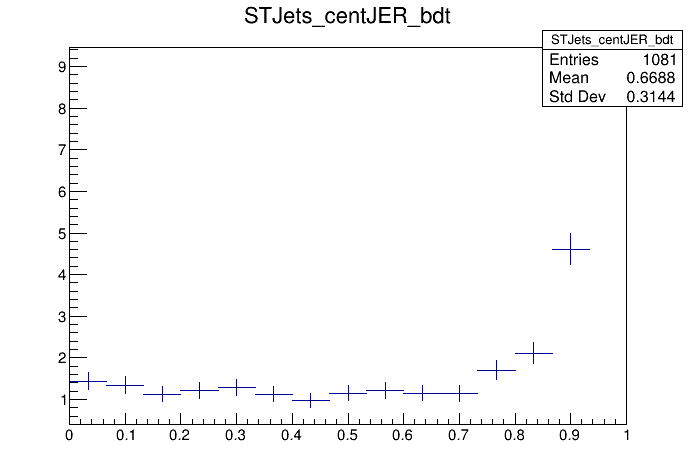

In [67]:
c = ROOT.TCanvas()
f.Get("STJets_centJER_bdt").Draw()
c.Draw()